**PRE MERGE QUALITY CHECKS**


In [ ]:
import pandas as pd

def check_missing_values(df):
    """Returns columns with missing values and their counts."""
    missing = df.isnull().sum()
    return missing[missing > 0]

def check_data_types(df):
    """Returns the data types of each column."""
    return df.dtypes

def check_duplicates(df):
    """Returns the number of duplicate rows."""
    return df.duplicated().sum()


In [ ]:
def handle_missing_values(df, strategy='drop', fill_value=None):
    """
    Handles missing values in the DataFrame.
    - strategy: 'drop' to remove rows with missing values, 'fill' to impute.
    - fill_value: Value to fill missing data if strategy is 'fill'.
    """
    
    if strategy == 'drop':
        return df.dropna()
    elif strategy == 'fill' and fill_value is not None:
        return df.fillna(fill_value)
    else:
        raise ValueError("Invalid strategy or fill_value not provided.")

def convert_data_types(df, conversions):
    """
    Converts columns to specified data types.
    - conversions: Dictionary with column names as keys and target data types as values.
    """
    for col, dtype in conversions.items():
        df[col] = df[col].astype(dtype, errors='ignore')
    return df

def remove_duplicates(df):
    """Removes duplicate rows from the DataFrame."""
    return df.drop_duplicates()


In [ ]:
# List of datasets with their respective file paths
datasets = {
    'Orders': '/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv',
    'Order Items': '/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv',
    'Order Payments': '/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv',
    'Order Reviews': '/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv',
    'Products': '/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv',
    'Sellers': '/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv',
    'Category Translation': '/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv'
}

# Dictionary to store cleaned DataFrames
cleaned_dataframes = {}

# Iterate over each dataset
for name, file_path in datasets.items():
    print(f"Processing {name} dataset...")
    
    # Load the dataset
    df = pd.read_csv(file_path)

    # Get the shape of the DataFrame
    rows, columns = df.shape
    print(f"The dataset contains {rows} rows and {columns} columns.")
    
    # Perform quality checks
    missing_values = check_missing_values(df)
    data_types = check_data_types(df)
    duplicate_count = check_duplicates(df)
    
    # Display quality check results
    print(f"Missing Values:\n{missing_values}\n")
    print(f"Data Types:\n{data_types}\n")
    print(f"Number of Duplicates: {duplicate_count}\n")
    
    # Data Cleaning Steps
    # Handle missing values

    # Drop specific columns in "Order Reviews" dataset with high missing values
    if name == 'Order Reviews':
        columns_to_drop = ['review_comment_title', 'review_comment_message']
        # Drop only if they exist in the dataset
        missing_columns = [col for col in columns_to_drop if col in missing_values and missing_values[col] > 0]
        if missing_columns:
            print(f"Dropping columns with high missing values in {name}: {missing_columns}")
            df.drop(missing_columns, axis=1, inplace=True)
    elif not missing_values.empty:
        # Example: Drop rows with missing values
        df = handle_missing_values(df, strategy='drop')
    
    # Convert data types
    # Example: Convert date columns to datetime
    date_columns = [col for col in df.columns if 'date' in col]
    conversions = {col: 'datetime64[ns]' for col in date_columns}
    df = convert_data_types(df, conversions)
    
    # Remove duplicates
    if duplicate_count > 0:
        df = remove_duplicates(df)
    
    # Store the cleaned DataFrame
    cleaned_dataframes[name] = df
    print(f"{name} dataset cleaned and stored.\n")


    #RE-CHECK-------------------------

    # Get the shape of the DataFrame
    rows, columns = df.shape
    print(f"The dataset contains {rows} rows and {columns} columns.")
    
    # Perform quality checks
    missing_values = check_missing_values(df)
    data_types = check_data_types(df)
    duplicate_count = check_duplicates(df)
    
    # Display quality check results
    print(f"Missing Values:\n{missing_values}\n")
    print(f"Data Types:\n{data_types}\n")
    print(f"Number of Duplicates: {duplicate_count}\n")


In [ ]:
#cleaned dataframes
keys = cleaned_dataframes.keys()
print("Keys in 'cleaned_dataframes':", keys)

# Verify the first few rows of each cleaned dataset
for name, df in cleaned_dataframes.items():
    print(f"First few rows of {name} dataset:")
    print(df.head(), "\n")

# Optionally, save cleaned datasets to new CSV files
for name, df in cleaned_dataframes.items():
    cleaned_file_path = f"cleaned_{name.lower().replace(' ', '_')}.csv"
    df.to_csv(cleaned_file_path, index=False)
    print(f"Cleaned {name} dataset saved to {cleaned_file_path}.")


**Relevant Columns for Each Dataset**

In [ ]:
# Define necessary columns for each dataset
required_columns = {
    'Orders': ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp'],
    'Order Items': ['order_id', 'product_id', 'seller_id', 'price', 'freight_value'],
    'Order Payments': ['order_id', 'payment_type', 'payment_value'],
    'Products': ['product_id', 'product_category_name'],
    'Sellers': ['seller_id', 'seller_city', 'seller_state'],
    'Order Reviews': ['order_id', 'review_score'],
    'Category Translation': ['product_category_name', 'product_category_name_english']
}


**Filter Each Dataset for Necessary Columns**

In [ ]:
# Dictionary to store filtered DataFrames
filtered_dataframes = {}

for name, columns in required_columns.items():
    # Select only the required columns from each cleaned DataFrame
    filtered_dataframes[name] = cleaned_dataframes[name][columns]
    print(f"Filtered columns for '{name}': {filtered_dataframes[name].columns.tolist()}")


**Merge the Filtered Datasets Dynamically**

In [ ]:
# Define the merge sequence dynamically: (DataFrame name, key to merge on)
merge_sequence = [
    ('Orders', 'order_id'),
    ('Order Items', 'order_id'),
    ('Order Payments', 'order_id'),
    ('Products', 'product_id'),
    ('Category Translation', 'product_category_name'),
    ('Sellers', 'seller_id'),
    ('Order Reviews', 'order_id')
]

# Initialize the base DataFrame with the first DataFrame in the sequence
base_df_name, base_key = merge_sequence[0]
base_df = filtered_dataframes[base_df_name]
print(f"Starting with base DataFrame: {base_df_name}")

# Sequentially merge each filtered DataFrame
for df_name, key in merge_sequence[1:]:
    print(f"Merging '{df_name}' into '{base_df_name}' on key '{key}'")
    base_df = pd.merge(base_df, filtered_dataframes[df_name], on=key, how='left')
    print(f"Shape after merging '{df_name}': {base_df.shape}")

# Final merged DataFrame
final_merged_df = base_df
print(f"\nFinal merged DataFrame shape: {final_merged_df.shape}")


**Verification and Final Check**

In [ ]:
# Display the first few rows of the final merged DataFrame
print(final_merged_df.head())

# Check for any remaining missing values
missing_values = final_merged_df.isnull().sum()
print("\nMissing values in the final merged DataFrame:\n", missing_values[missing_values > 0])


**POST MERGE QUALITY CHECKS**

*Missing Values*

In [ ]:
missing_values = final_merged_df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

total_rows = final_merged_df.shape[0]
missing_percentage = (missing_values / total_rows) * 100
print("Percentage of missing values per column:")
print(missing_percentage[missing_percentage > 0])

In [ ]:
# Example: Dropping columns with more than 50% missing values
threshold = 50.0  # percentage
columns_to_drop = missing_percentage[missing_percentage > threshold].index

# Check and drop columns if any exceed the threshold
if len(columns_to_drop) > 0:
    print(f"Columns to drop (more than {threshold}% missing values): {list(columns_to_drop)}")
    final_merged_df.drop(columns=columns_to_drop, inplace=True)
else:
    print("No columns exceed the missing value threshold.")

In [ ]:
# Calculate the threshold: number of columns minus allowed missing values
threshold = final_merged_df.shape[1] - 2  # Allow up to 2 missing values per row

# Drop rows with missing values exceeding the threshold
cleaned_df = final_merged_df.dropna(thresh=threshold)

# Display the number of rows removed
rows_removed = final_merged_df.shape[0] - cleaned_df.shape[0]
print(f"Number of rows removed: {rows_removed}")


*Validate Datatypes*

In [ ]:
print("Data types before conversion:")
print(final_merged_df.dtypes)


In [ ]:
# Example: Converting date columns to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    if col in final_merged_df.columns:
        final_merged_df[col] = pd.to_datetime(final_merged_df[col], errors='coerce')
print("Data types after conversion:")
print(final_merged_df.dtypes)


*Duplicate Values*

In [ ]:
duplicate_rows = final_merged_df[final_merged_df.duplicated(keep=False)]
if not duplicate_rows.empty:
    print(f"Warning: Found {duplicate_rows.shape[0]} duplicate rows.")
else:
    print("No duplicate rows found.")


In [ ]:
final_merged_df.drop_duplicates(inplace=True)
print("Duplicate rows removed.")


*Data Consistency*

Numerical Variables

In [ ]:
# Define expected ranges for numerical columns
expected_ranges = {
    'price': (0, None),  # No negative prices, upper limit None (unbounded)
    'freight_value': (0, None),  # Freight value should be non-negative
    'payment_value': (0, None),  # Payment values should be non-negative
    'review_score': (1, 5)  # Assuming review scores are between 1 and 5
}

# Loop through numerical columns and validate their ranges
for col, dtype in final_merged_df.dtypes.items():
    if dtype == 'float64' or dtype == 'int64':  # Identifying numerical columns
        if col in expected_ranges:
            min_val, max_val = expected_ranges[col]
            
            # Check for values below the expected minimum
            if min_val is not None:
                below_min = final_merged_df[final_merged_df[col] < min_val]
                if not below_min.empty:
                    print(f"Warning: Found {below_min.shape[0]} entries in '{col}' below the minimum expected value of {min_val}. Setting them to {min_val}.")
                    final_merged_df.loc[final_merged_df[col] < min_val, col] = min_val
            
            # Check for values above the expected maximum
            if max_val is not None:
                above_max = final_merged_df[final_merged_df[col] > max_val]
                if not above_max.empty:
                    print(f"Warning: Found {above_max.shape[0]} entries in '{col}' above the maximum expected value of {max_val}. Setting them to {max_val}.")
                    final_merged_df.loc[final_merged_df[col] > max_val, col] = max_val
        else:
            print(f"No expected range specified for '{col}'. Please review this column manually if needed.")


Categorical Variables

In [ ]:
import pandas as pd

# Columns that require standardization (categorical text columns)
categorical_columns = [
    'order_status', 'payment_type', 
    'product_category_name', 'product_category_name_english', 
    'seller_city', 'seller_state'
]

# Function to standardize categorical data
def standardize_categorical_data(df, columns):
    for col in columns:
        if col in df.columns:
            # Convert to lowercase, replace spaces with underscores, and remove special characters
            df[col] = df[col].str.lower().str.replace(' ', '_').str.replace(r'[^a-z0-9_]', '', regex=True)
    return df

# Applying the function to standardize selected categorical columns
final_merged_df = standardize_categorical_data(final_merged_df, categorical_columns)

# Verify the results
print("Standardized Categorical Columns:")
for col in categorical_columns:
    print(f"{col} unique values after standardization:\n{final_merged_df[col].unique()}\n")


Mapping if needed for categorical variables  ------- **CAUTION ---**

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade packaging

pip install --upgrade skrub

import sys
!{sys.executable} -m pip show packaging

!{sys.executable} -m pip show skrub



!{sys.executable} -m pip uninstall skrub -y packaging

pip install skrub packaging

import pandas as pd
from skrub import SimilarityEncoder

# Initialize the SimilarityEncoder
encoder = SimilarityEncoder(similarity='ngram', ngram_range=(2, 4), categories='auto')

# Function to encode and replace categorical columns
def encode_categorical_columns(df, columns):
    for col in columns:
        if col in df.columns:
            # Reshape the column to a 2D array as required by the encoder
            col_data = df[[col]].astype(str).values
            # Fit and transform the data
            encoded_data = encoder.fit_transform(col_data)
            # Create a DataFrame with the encoded data
            encoded_df = pd.DataFrame(encoded_data, index=df.index)
            # Rename columns to reflect the original column name
            encoded_df.columns = [f"{col}_encoded_{i}" for i in range(encoded_df.shape[1])]
            # Drop the original column and concatenate the encoded columns
            df = df.drop(columns=[col]).join(encoded_df)
    return df

# Apply the encoding to the DataFrame
final_merged_df = encode_categorical_columns(final_merged_df, categorical_columns)


#checking for consistency
for col in categorical_columns:
    encoded_cols = [c for c in final_merged_df.columns if c.startswith(f"{col}_encoded_")]
    if encoded_cols:
        print(f"Column '{col}' has been encoded into {len(encoded_cols)} columns.")
    else:
        print(f"Warning: Column '{col}' was not found or encoded.")

#review after encoding
# Display the first few rows of the encoded DataFrame
print(final_merged_df.head())


*Referential Integrity Checks*

In [ ]:
# Example: Checking for orphaned 'product_id' entries
if 'product_id' in final_merged_df.columns:
    unique_product_ids = final_merged_df['product_id'].unique()
    # Assuming 'products_df' is the original products DataFrame
    missing_products = set(unique_product_ids) - set(filtered_dataframes['Products']['product_id'].unique())
    if missing_products:
        print(f"Warning: Found {len(missing_products)} 'product_id' entries without matching records in products data.")
    else:
        print("All 'product_id' entries have matching records in products data.")


In [ ]:
# Example: Removing rows with missing 'product_id' references
if 'product_id' in final_merged_df.columns:
    final_merged_df = final_merged_df[final_merged_df['product_id'].isin(filtered_dataframes['Products']['product_id'])]
    print("Removed rows with orphaned 'product_id' references.")


*Statistical Summaries*

In [ ]:
print("Descriptive statistics for numerical columns:")
print(final_merged_df.describe())

*Frequency Distribution*

In [ ]:
import matplotlib.pyplot as plt

# Example: Plotting histograms for key numerical columns to visualize distributions
numerical_columns = final_merged_df.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(final_merged_df[col].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


*Validate Business Logic*

In [ ]:
final_merged_df.columns

**CAUTION -- Date Columns**

In [ ]:
# Example: Checking logical date relationships
if 'order_approved_at' in final_merged_df.columns and 'order_delivered_customer_date' in final_merged_df.columns:
    invalid_dates = final_merged_df[final_merged_df['order_delivered_customer_date'] < final_merged_df['order_approved_at']]
    if not invalid_dates.empty:
        print(f"Warning: Found {invalid_dates.shape[0]} records with 'order_delivered_customer_date' earlier than 'order_approved_at'.")
    else:
        print("All date relationships are valid.")


In [ ]:
# Example: Validating 'order_status' values
if 'order_status' in final_merged_df.columns:
    valid_statuses = ['delivered', 'shipped', 'canceled', 'processing']
    invalid_statuses = final_merged_df[~final_merged_df['order_status'].isin(valid_statuses)]
    if not invalid_statuses.empty:
        print(f"Warning: Found {invalid_statuses.shape[0]} entries with unexpected 'order_status' values.")
    else:
        print("All 'order_status' values are valid.")


**Saving the Final Dataset**

In [ ]:
# Save the DataFrame to a CSV file
final_merged_df.to_csv('final_merged_df.csv', index=False)


In [ ]:
final_merged_df.shape

In [ ]:
#Dataset Basic Information

# Display the first few rows
print("First few rows of the dataset:")
print(final_merged_df.head())

# Display basic information
print("\nDataset Information:")
print(final_merged_df.info())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(final_merged_df.describe())

**Exploratory Data Analysis**

In [1]:
#Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Reading the final df CSV file

final_merged_df = pd.read_csv('/kaggle/input/final-merged-dataset/final_merged_df.csv')

In [3]:
#Dataset Basic Information

# Display the first few rows
print("First few rows of the dataset:")
print(final_merged_df.head())

# Display basic information
print("\nDataset Information:")
print(final_merged_df.info())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(final_merged_df.describe())


First few rows of the dataset:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp                        product_id  \
0    delivered      2017-10-02 10:56:33  87285b34884572647811a353c7ac498a   
1    delivered      2017-10-02 10:56:33  87285b34884572647811a353c7ac498a   
2    delivered      2017-10-02 10:56:33  87285b34884572647811a353c7ac498a   
3    delivered      2018-07-24 20:41:37  595fac2a385ac33a80bd5114aec74eb8   
4    delivered      2018-08-08 08:38:49  aa4383b373c6aca5d8797843e5594415   

                          seller_id   price  freight_value payment_

In [4]:
#Checking Missing Values


# Calculate the number and percentage of missing values per column
missing_values = final_merged_df.isnull().sum()
missing_percentage = (missing_values / final_merged_df.shape[0]) * 100

# Combine into a DataFrame for better readability
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

# Filter columns with missing values
missing_data = missing_data[missing_data['Missing Values'] > 0]

print("\nMissing Values per Column:")
print(missing_data)



Missing Values per Column:
                               Missing Values  Percentage
payment_type                                1    0.000973
payment_value                               1    0.000973
product_category_name_english              21    0.020425
review_score                              712    0.692513


*Categorical*

In [5]:
#Distribution of Categorical Variables

# Identify categorical columns
categorical_columns = final_merged_df.select_dtypes(include=['object']).columns

# Display number of unique values in the categorical columns
for col in categorical_columns:
    unique_values = final_merged_df[col].nunique()
    print(f"'{col}' has {unique_values} unique categories.")

'order_id' has 95129 unique categories.
'customer_id' has 95129 unique categories.
'order_status' has 2 unique categories.
'order_purchase_timestamp' has 94625 unique categories.
'product_id' has 31625 unique categories.
'seller_id' has 2914 unique categories.
'payment_type' has 4 unique categories.
'product_category_name' has 73 unique categories.
'product_category_name_english' has 71 unique categories.
'seller_city' has 586 unique categories.
'seller_state' has 22 unique categories.


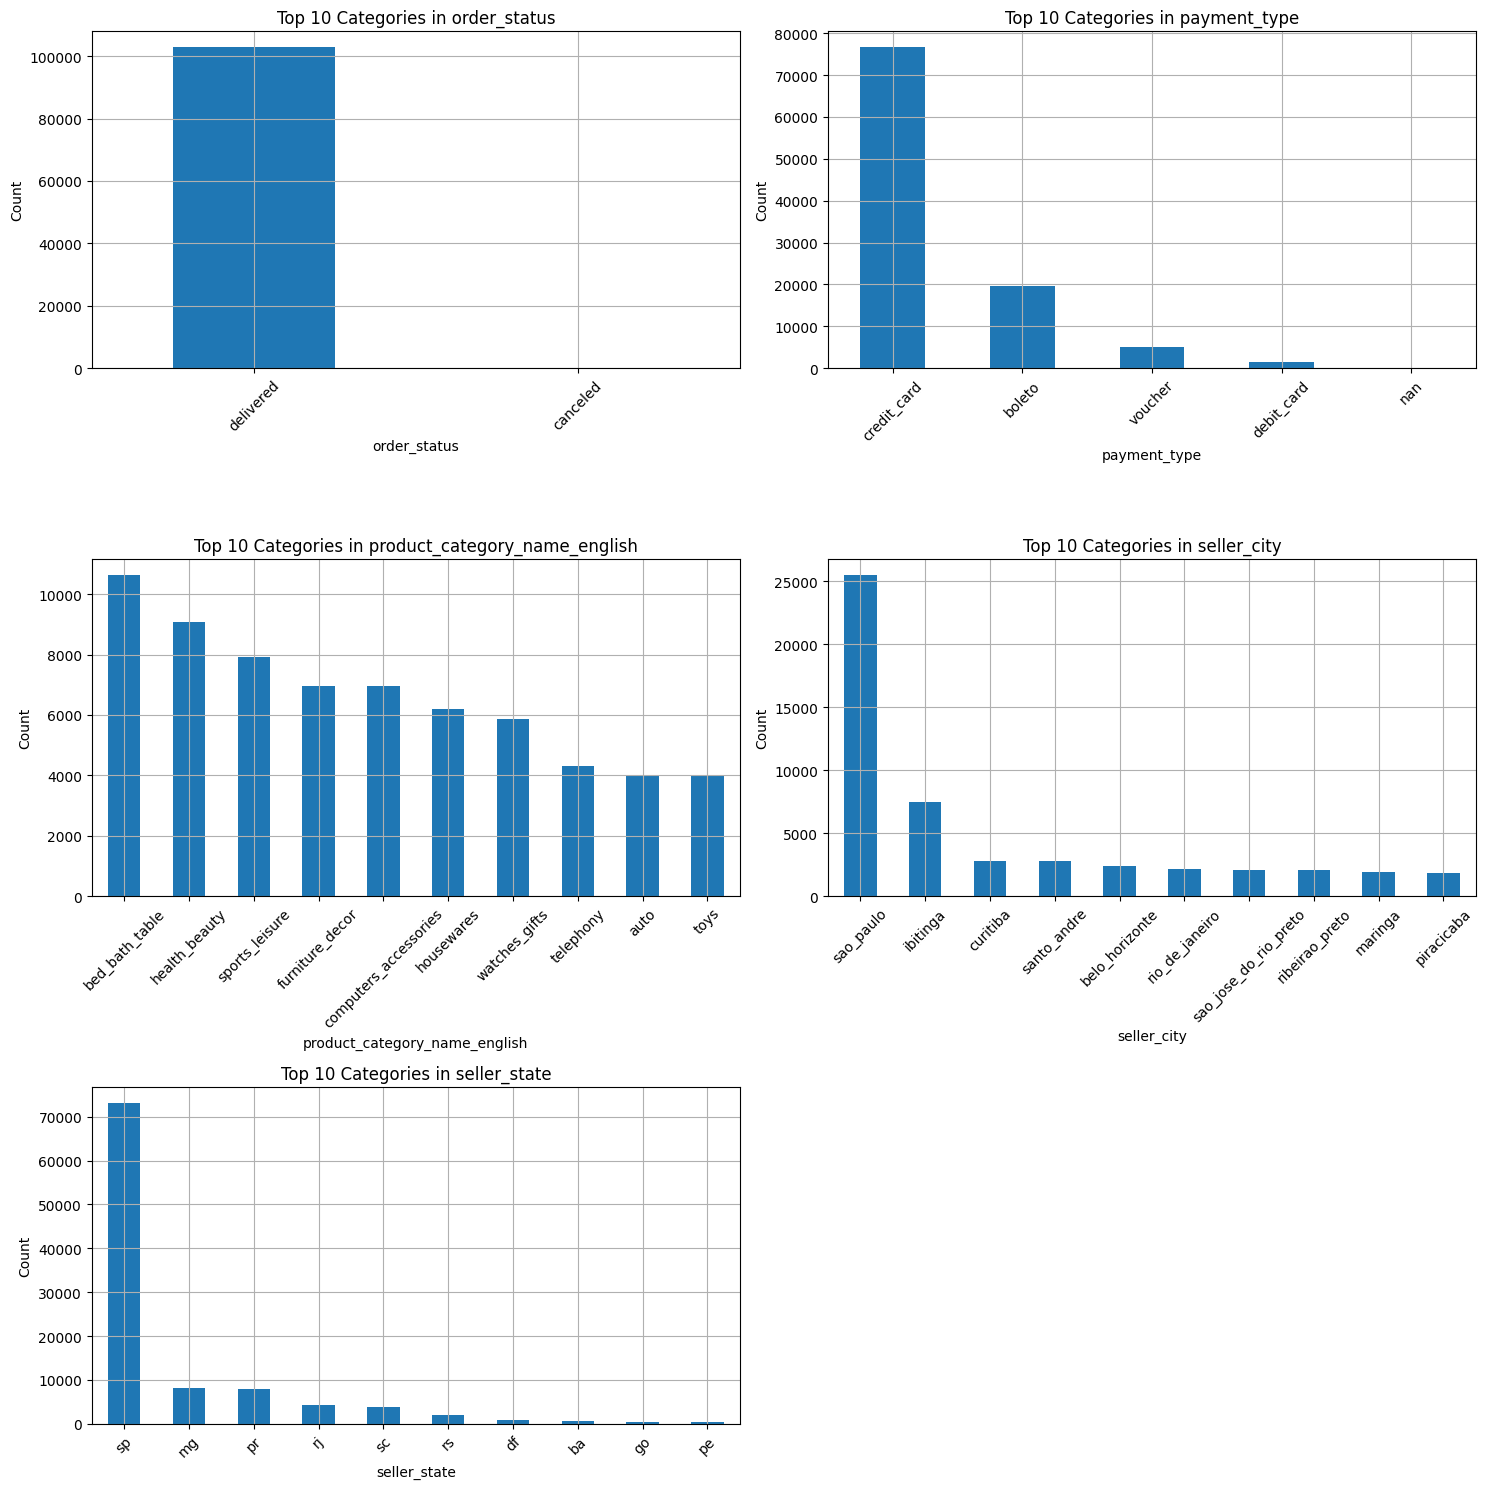

In [6]:
import matplotlib.pyplot as plt
import math

# List of columns to analyze
columns_to_analyze = ['order_status', 'payment_type', 'product_category_name_english', 'seller_city', 'seller_state']

# Define the number of top categories to display
top_n = 10

# Number of plots per row
plots_per_row = 2

# Calculate the number of rows needed
num_rows = math.ceil(len(columns_to_analyze) / plots_per_row)

# Create a figure with the calculated number of subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each specified column and corresponding subplot axis
for idx, col in enumerate(columns_to_analyze):
    if col in final_merged_df.columns:
        # Calculate the top N categories
        top_categories = final_merged_df[col].value_counts(dropna=False).nlargest(top_n)
        
        # Plot the distribution of the top N categories
        ax = axes[idx]
        top_categories.plot(kind='bar', ax=ax)
        ax.set_title(f'Top {top_n} Categories in {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.grid(True)
    else:
        print(f"Column '{col}' not found in the DataFrame.")

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


*Numerical*

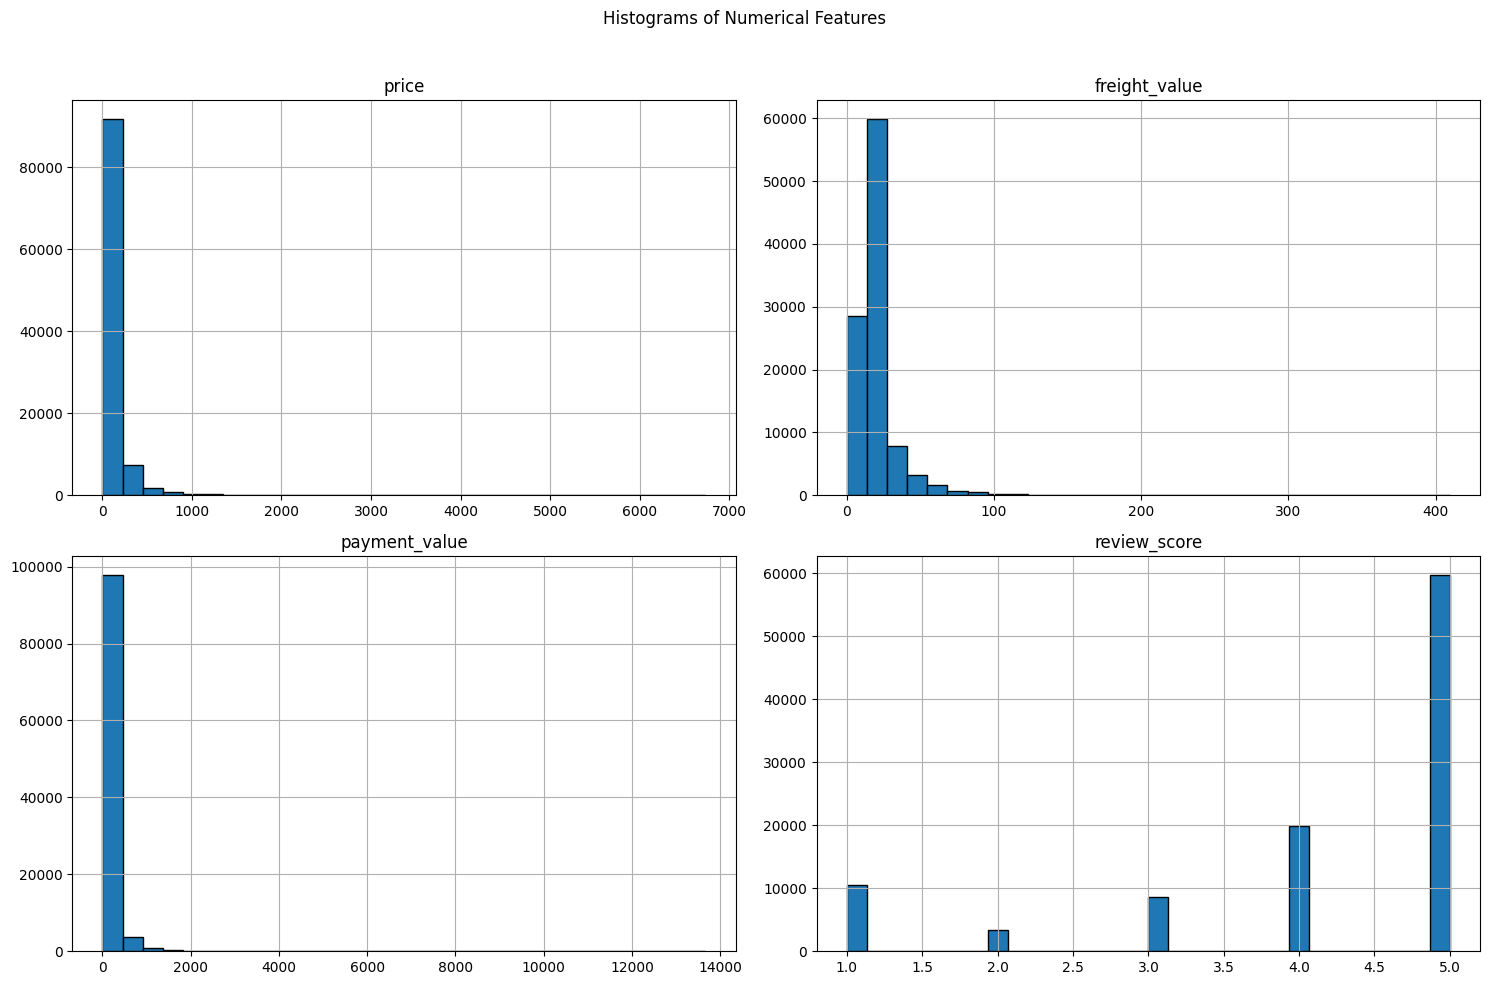

In [7]:
#Distribution of Numerical Variables

# Identify numerical columns
numerical_columns = final_merged_df.select_dtypes(include=['number']).columns

# Plot histograms for numerical columns
final_merged_df[numerical_columns].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


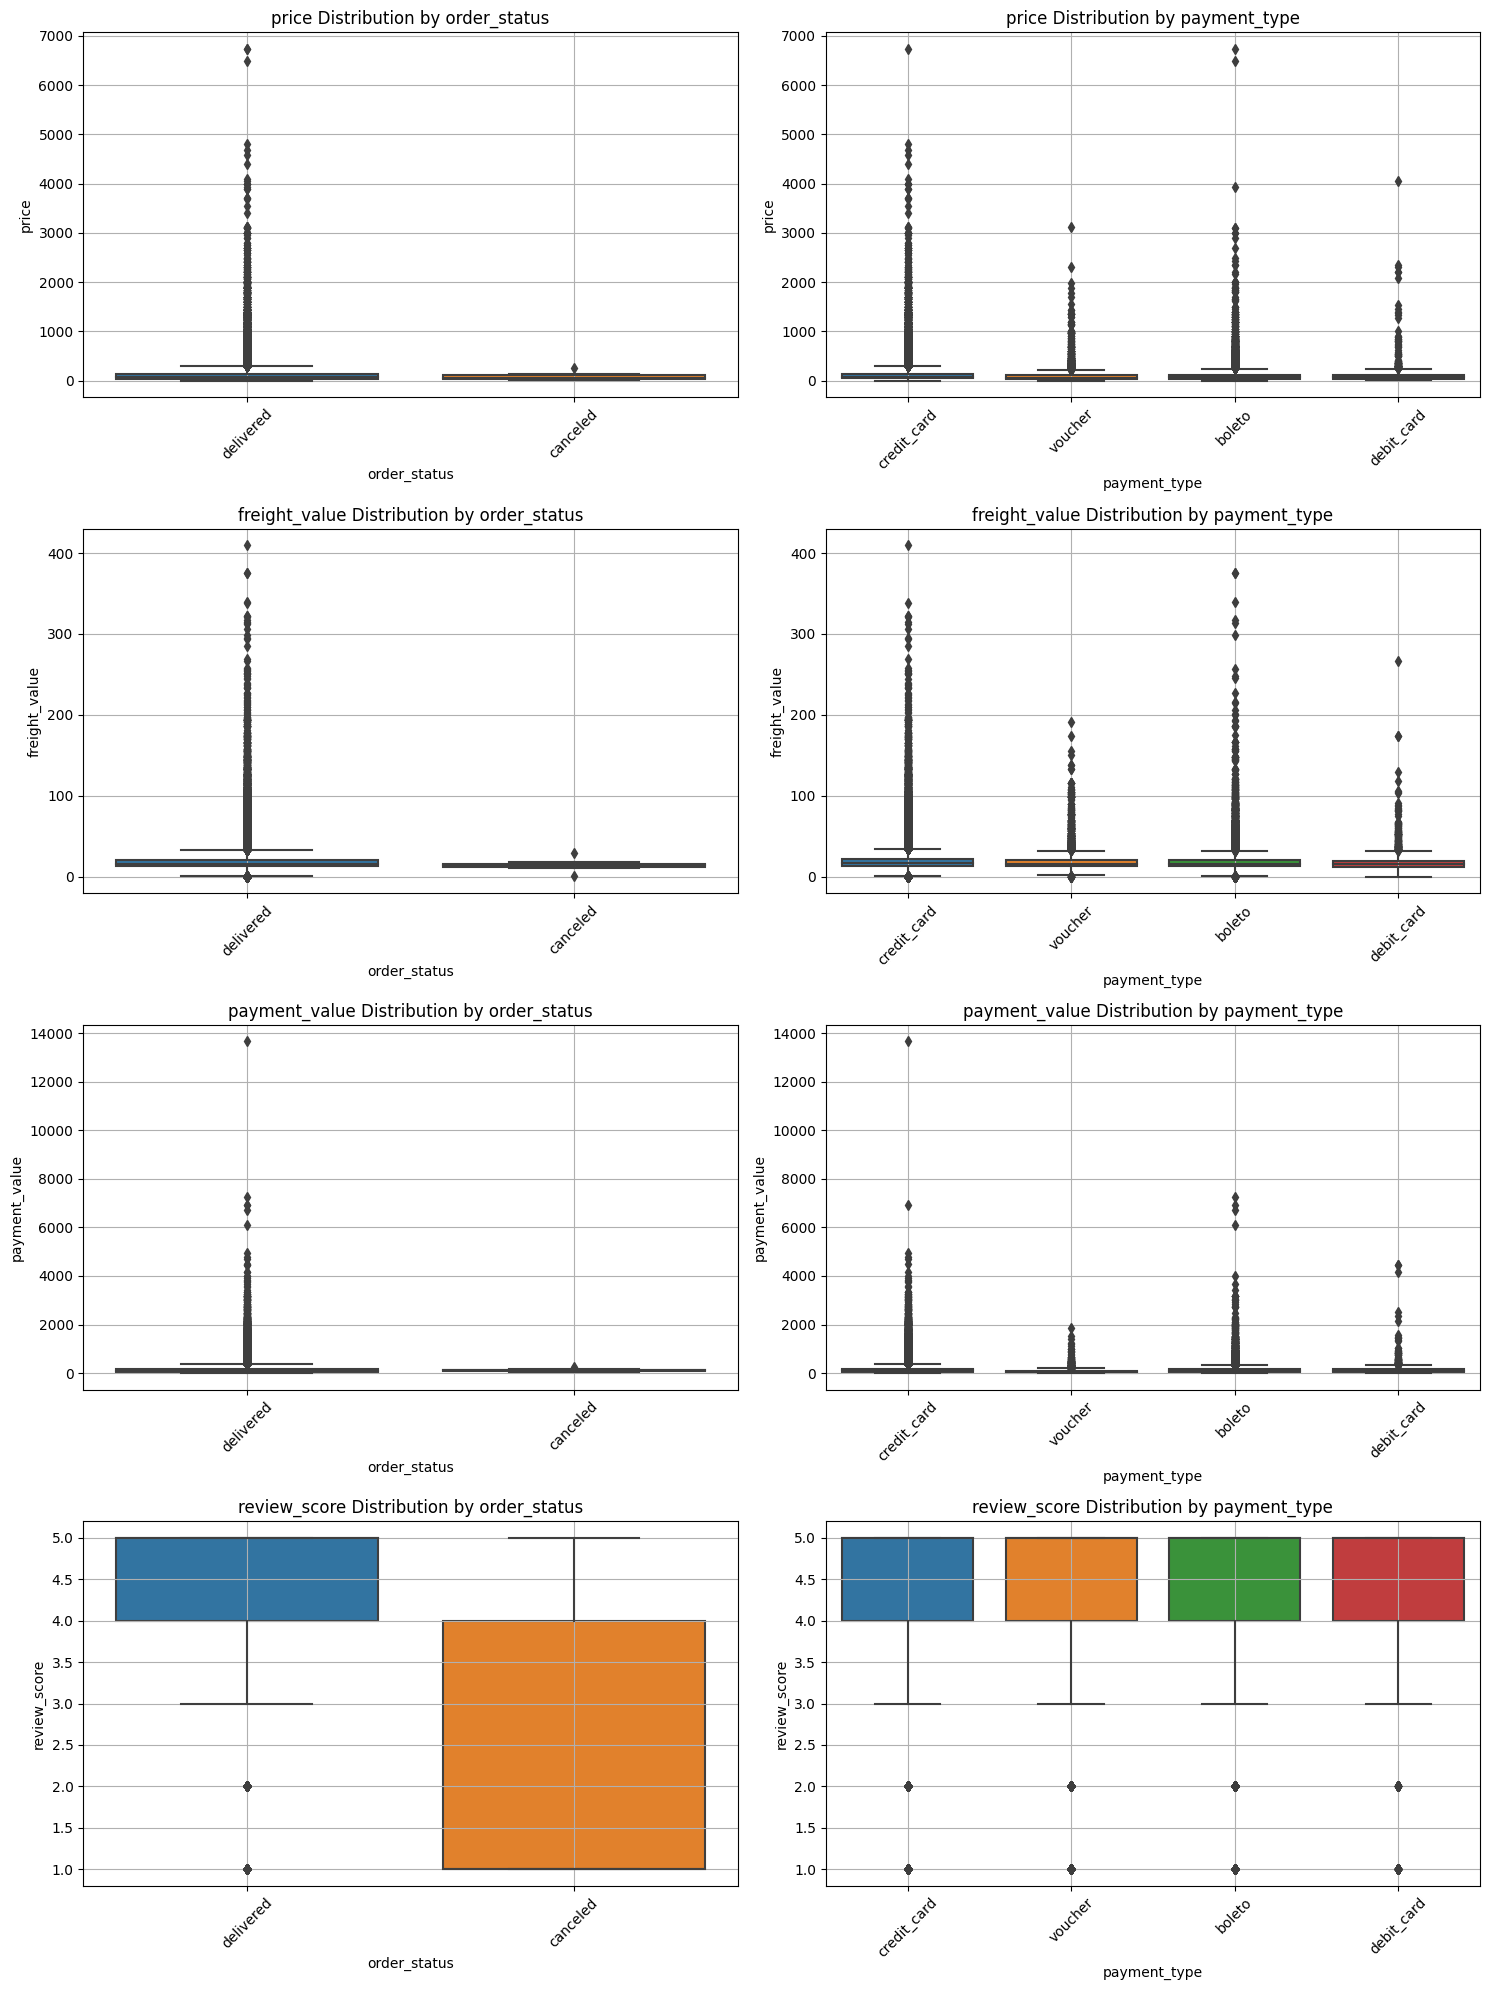

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Number of plots per row
plots_per_row = 2

# Filtered lists of columns for manageable plots
numerical_columns = final_merged_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = [col for col in final_merged_df.select_dtypes(include=['object']).columns if final_merged_df[col].nunique() <= 20]

# Calculate the total number of plots needed
total_plots = len(numerical_columns) * len(categorical_columns)
num_rows = math.ceil(total_plots / plots_per_row)

# Set up figure with calculated number of rows
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten axes for easier indexing

# Initialize plot index
plot_idx = 0

# Generate box plots
for num_col in numerical_columns:
    for cat_col in categorical_columns:
        if plot_idx < total_plots:
            sns.boxplot(data=final_merged_df, x=cat_col, y=num_col, ax=axes[plot_idx])
            axes[plot_idx].set_title(f'{num_col} Distribution by {cat_col}')
            axes[plot_idx].set_xlabel(cat_col)
            axes[plot_idx].set_ylabel(num_col)
            axes[plot_idx].tick_params(axis='x', rotation=45)
            axes[plot_idx].grid(True)
            plot_idx += 1

# Remove any unused subplots if total_plots < len(axes)
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


*Correlation Matrix*

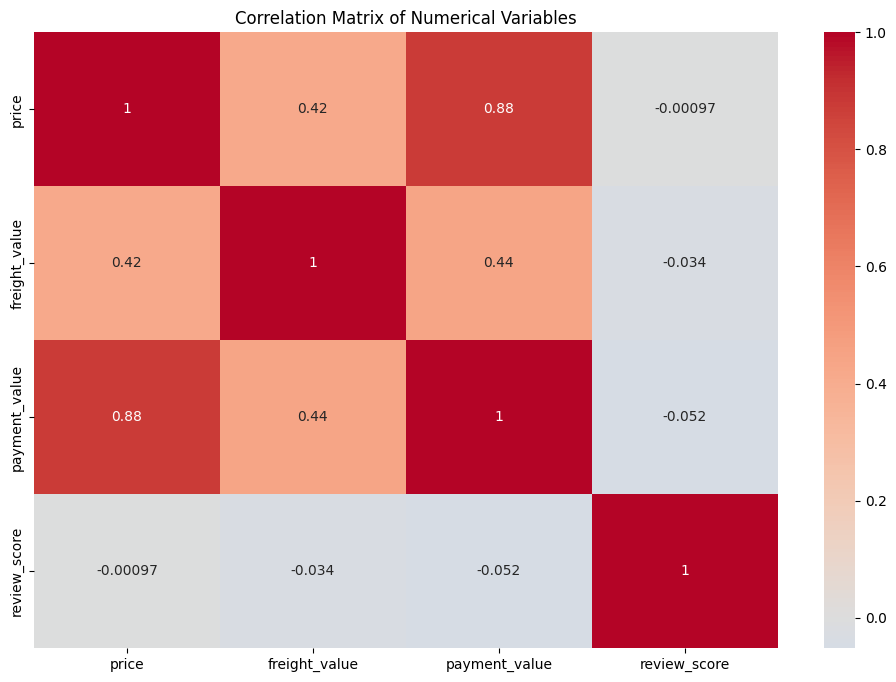

In [9]:
# Compute correlation matrix
correlation_matrix = final_merged_df[numerical_columns].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()


*Time Series Analysis*

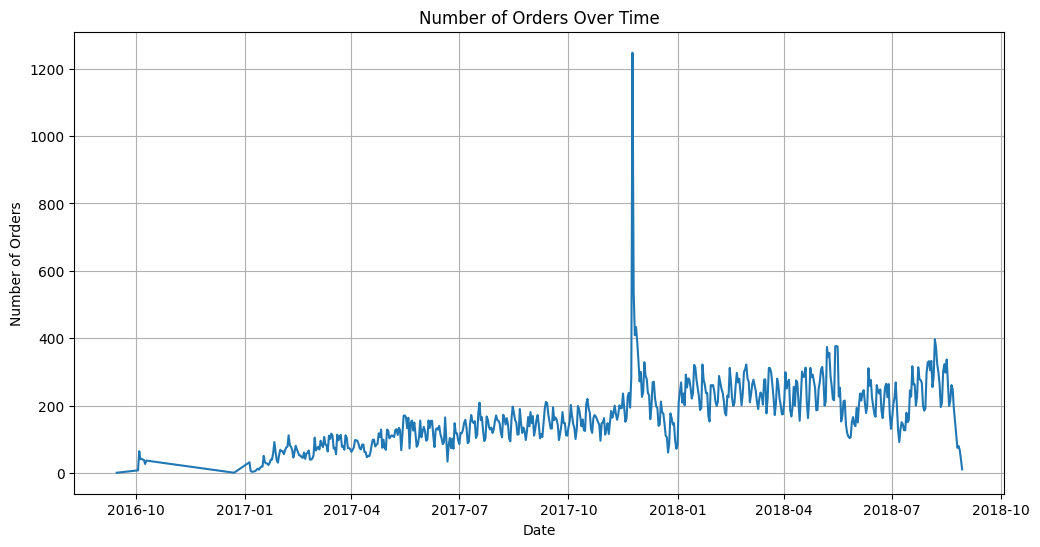

In [10]:
#Analyse Trends over time

# Ensure 'order_purchase_timestamp' is in datetime format
final_merged_df['order_purchase_timestamp'] = pd.to_datetime(final_merged_df['order_purchase_timestamp'])

# Extract date-related features
final_merged_df['order_date'] = final_merged_df['order_purchase_timestamp'].dt.date
final_merged_df['order_month'] = final_merged_df['order_purchase_timestamp'].dt.to_period('M')

# Plot order counts over time
order_counts = final_merged_df['order_date'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
order_counts.plot()
plt.title('Number of Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()


/tmp/ipykernel_29/278976352.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_orders = time_series_df['order_id'].resample('M').count()


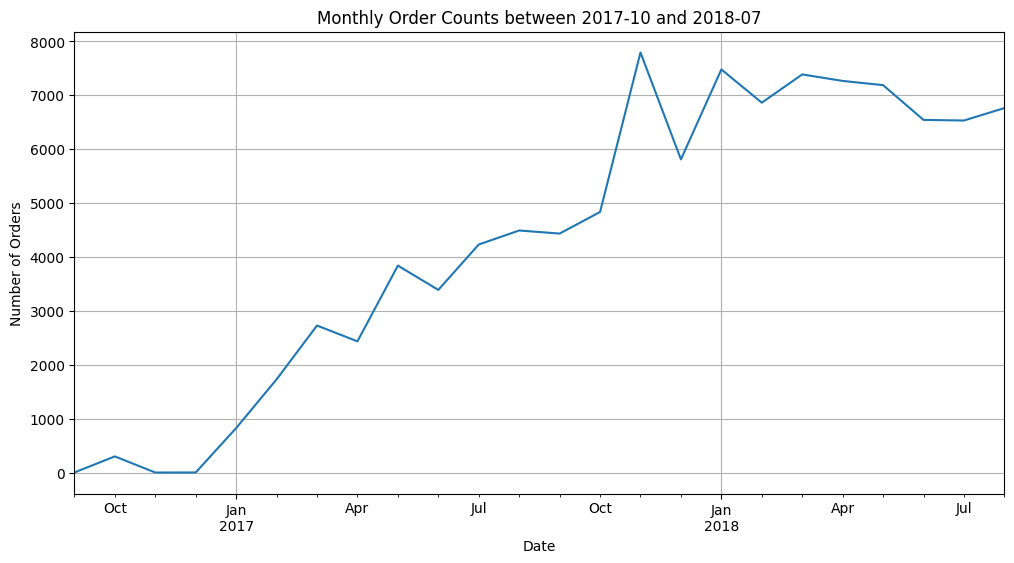

In [11]:
# Ensure 'order_purchase_timestamp' is in datetime format
final_merged_df['order_purchase_timestamp'] = pd.to_datetime(final_merged_df['order_purchase_timestamp'])

# Set the order purchase timestamp as the index
time_series_df = final_merged_df.set_index('order_purchase_timestamp')

# Resample to get monthly order counts
monthly_orders = time_series_df['order_id'].resample('M').count()

# Plot the time series
plt.figure(figsize=(12, 6))
monthly_orders.plot()
plt.title('Monthly Order Counts between 2017-10 and 2018-07')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()


*Pairwise Relationships*

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

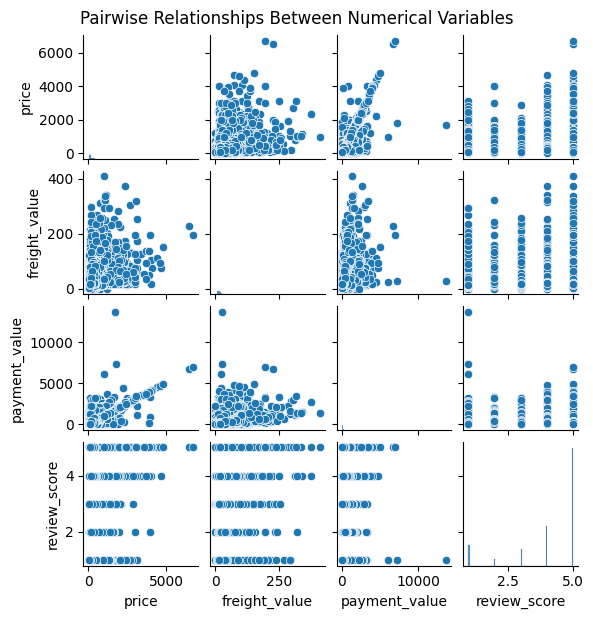

In [12]:
# Select a subset of numerical columns for pairplot
subset_numerical_columns = numerical_columns[:5]  # Adjust the number as needed

# Plot pairplot
sns.pairplot(final_merged_df[subset_numerical_columns].dropna(), height=1.5)
plt.suptitle('Pairwise Relationships Between Numerical Variables', y=1.02)
plt.show()


*Geographical Trends* 

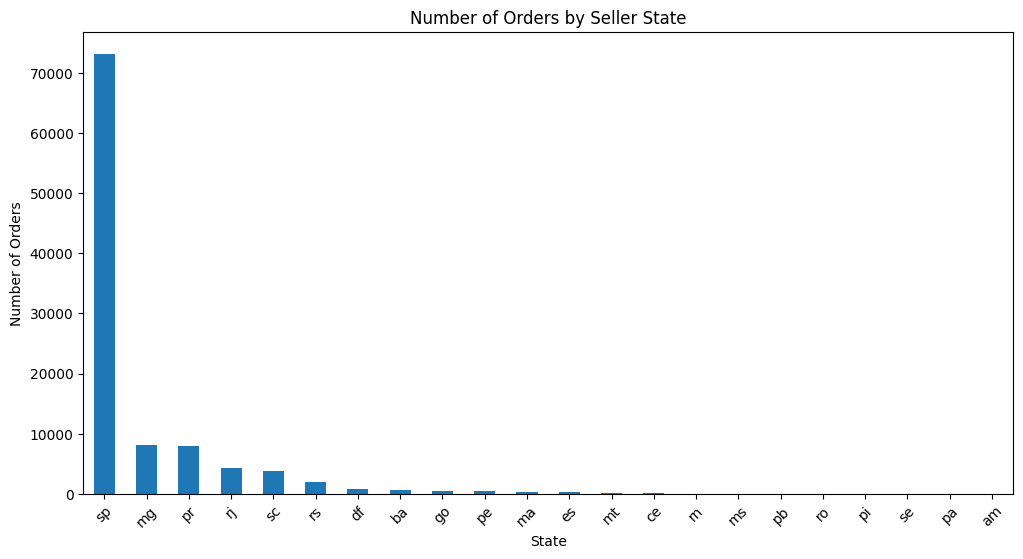

In [13]:
#Analysing Geographical Data

# Plot the distribution of orders by state
plt.figure(figsize=(12, 6))
final_merged_df['seller_state'].value_counts().plot(kind='bar')
plt.title('Number of Orders by Seller State')
plt.xlabel('State')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


**Feature Engineering**

In [3]:
final_merged_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'product_id', 'seller_id', 'price', 'freight_value', 'payment_type',
       'payment_value', 'product_category_name',
       'product_category_name_english', 'seller_city', 'seller_state',
       'review_score'],
      dtype='object')

In [4]:
import numpy as np
import pandas as pd

# Address Skewness
def address_skewness(df, columns):
    """
    Apply log transformation to handle skewness for specified columns.
    """
    for col in columns:
        if col in df.columns:
            df[f'{col}_log'] = np.log1p(df[col])  # Add 1 to avoid log(0) issues
    return df

# Remove Redundant Features
def remove_redundant_features(df, redundant_columns):
    """
    Drop redundant features from the DataFrame to reduce multicollinearity.
    """
    return df.drop(columns=[col for col in redundant_columns if col in df.columns])

# Create Regional Demand Indicator
def create_regional_demand_indicator(df, region_column):
    """
    Create a regional demand indicator based on counts of transactions per region.
    """
    if region_column in df.columns:
        region_demand = df[region_column].value_counts().to_dict()
        df['regional_demand'] = df[region_column].map(region_demand)
    return df

# Create Discount or Promotion Feature
def create_promotion_feature(df, date_column, promo_start, promo_end):
    """
    Create a binary feature indicating whether the transaction occurred during a promotional period.
    """
    if date_column in df.columns:
        df['is_promotion_period'] = df[date_column].between(promo_start, promo_end).astype(int)
    return df

# Create Customer Satisfaction Indicator
def create_customer_satisfaction_indicator(df, review_score_column):
    """
    Derive customer satisfaction levels based on review scores.
    """
    if review_score_column in df.columns:
        df['customer_satisfaction'] = pd.cut(
            df[review_score_column],
            bins=[0, 2, 4, 5],  # Custom bins for Low (0-2), Medium (2-4), High (4-5)
            labels=['Low', 'Medium', 'High']
        )
    return df

# Apply transformations and feature engineering
numerical_columns = ['price', 'freight_value', 'payment_value']
redundant_columns = ['payment_value']  # Remove one of the highly correlated features
region_column = 'seller_state'
date_column = 'order_purchase_timestamp'
promo_start = '2017-10-01'  
promo_end = '2017-11-30'
review_score_column = 'review_score'

# 1. Address skewness
final_merged_df = address_skewness(final_merged_df, numerical_columns)

# 2. redundant features
final_merged_df = remove_redundant_features(final_merged_df, redundant_columns)

# 3. Regional Demand Indicator
final_merged_df = create_regional_demand_indicator(final_merged_df, region_column)

# 4. Promotion Feature
final_merged_df = create_promotion_feature(final_merged_df, date_column, promo_start, promo_end)

# 5. Customer Satisfaction Indicator
final_merged_df = create_customer_satisfaction_indicator(final_merged_df, review_score_column)

# summary of the transformed DataFrame
print(final_merged_df.head())


                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp                        product_id  \
0    delivered      2017-10-02 10:56:33  87285b34884572647811a353c7ac498a   
1    delivered      2017-10-02 10:56:33  87285b34884572647811a353c7ac498a   
2    delivered      2017-10-02 10:56:33  87285b34884572647811a353c7ac498a   
3    delivered      2018-07-24 20:41:37  595fac2a385ac33a80bd5114aec74eb8   
4    delivered      2018-08-08 08:38:49  aa4383b373c6aca5d8797843e5594415   

                          seller_id   price  freight_value payment_type  \
0  3504c0cb71d7fa48d967

*Validation and Analysis of new features*


Feature: regional_demand
Unique Values: 22
Sample Data:
regional_demand
73116    73116
8116      8116
7943      7943
4345      4345
3806      3806
2023      2023
836        836
585        585
483        483
423        423
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


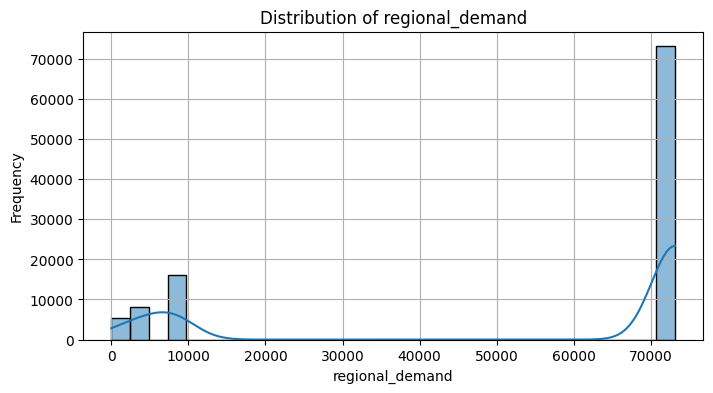


Feature: is_promotion_period
Unique Values: 2
Sample Data:
is_promotion_period
0    90464
1    12350
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


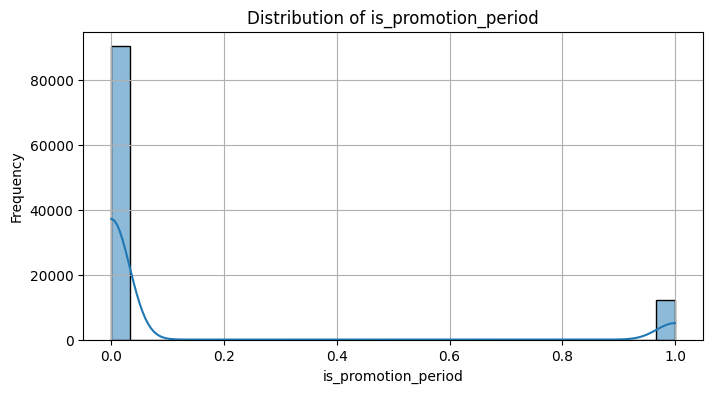


Feature: customer_satisfaction
Unique Values: 3
Sample Data:
customer_satisfaction
High      59711
Medium    28463
Low       13928
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


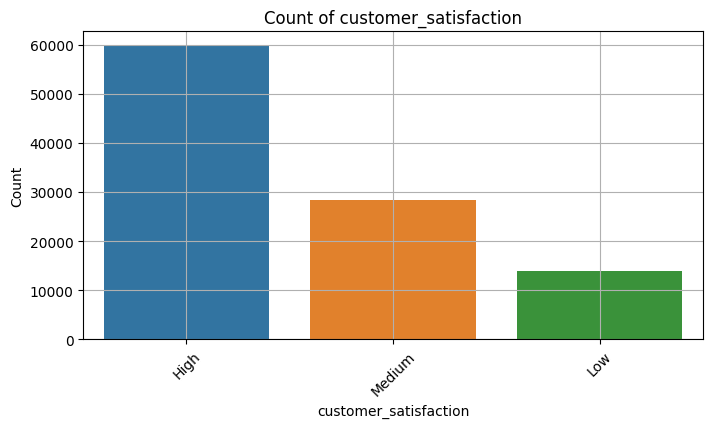

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


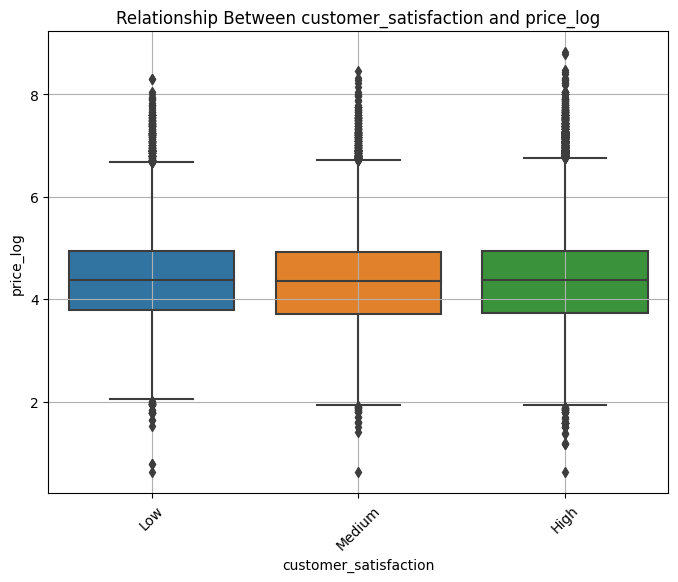

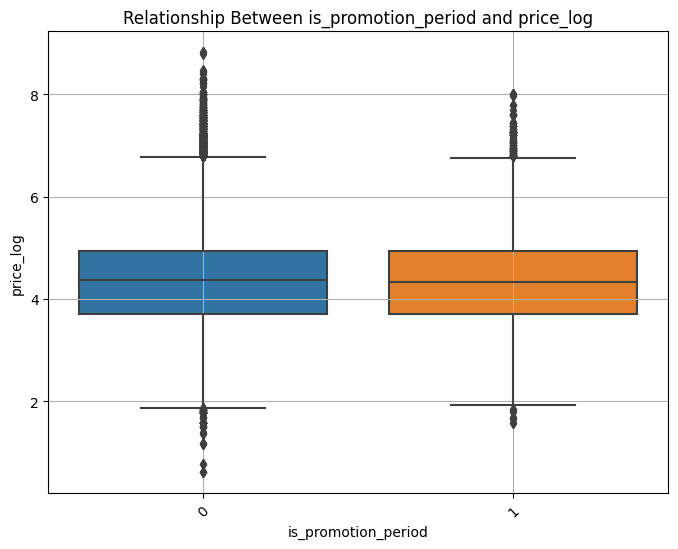

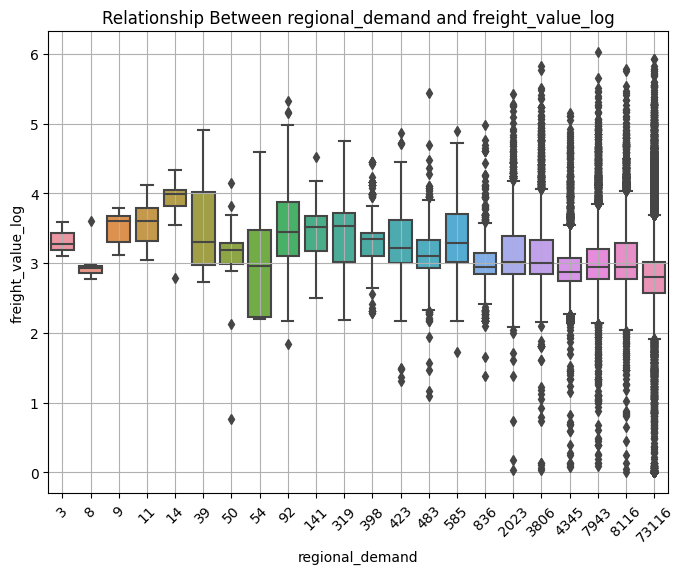


Sample Data After Scaling:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp                        product_id  \
0    delivered      2017-10-02 10:56:33  87285b34884572647811a353c7ac498a   
1    delivered      2017-10-02 10:56:33  87285b34884572647811a353c7ac498a   
2    delivered      2017-10-02 10:56:33  87285b34884572647811a353c7ac498a   
3    delivered      2018-07-24 20:41:37  595fac2a385ac33a80bd5114aec74eb8   
4    delivered      2018-08-08 08:38:49  aa4383b373c6aca5d8797843e5594415   

                          seller_id   price  freight_value payment_typ

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Validate and Explore the New Features
def validate_features(df, features):
    """
    Validate and explore the distributions and relationships of the new features.
    """
    for feature in features:
        if feature in df.columns:
            unique_vals = df[feature].nunique()
            print(f"\nFeature: {feature}")
            print(f"Unique Values: {unique_vals}")
            print(f"Sample Data:\n{df[feature].value_counts().head(10)}")
            
            # Visualize distribution for continuous and binary features
            if df[feature].dtype in ['float64', 'int64']:
                #print("Started Numerical Validation")
                plt.figure(figsize=(8, 4))
                sns.histplot(df[feature], kde=True, bins=30)
                plt.title(f'Distribution of {feature}')
                plt.xlabel(feature)
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()
            
            # Visualize categorical features
            elif df[feature].dtype == 'object' or unique_vals <= 10:  # Treating small unique counts as categorical
                #print("Satrted Categorical Validation")
                plt.figure(figsize=(8, 4))
                sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)
                plt.title(f'Count of {feature}')
                plt.xlabel(feature)
                plt.ylabel('Count')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.show()

# Features to validate
new_features = ['regional_demand', 'is_promotion_period', 'customer_satisfaction']

#print("Started Validation")

validate_features(final_merged_df, new_features)

# 2. Analyze Relationships Between New Features
def analyze_feature_relationships(df, feature_pairs):
    """
    Analyze the relationships between the new features and key variables.
    """
    for pair in feature_pairs:
        feature1, feature2 = pair
        #print(feature1, feature2)
        if feature1 in df.columns and feature2 in df.columns:
            plt.figure(figsize=(8, 6))
            sns.boxplot(data=df, x=feature1, y=feature2)
            plt.title(f'Relationship Between {feature1} and {feature2}')
            plt.xlabel(feature1)
            plt.ylabel(feature2)
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()

# Define feature pairs to analyze
feature_relationships = [
    ('customer_satisfaction', 'price_log'),
    ('is_promotion_period', 'price_log'),
    ('regional_demand', 'freight_value_log')
]

#print("Started Feature Relationships")
analyze_feature_relationships(final_merged_df, feature_relationships)

# 3. Feature Scaling for Numerical Variables
def scale_features(df, numerical_features):
    """
    Apply Min-Max Scaling or Standard Scaling to numerical features.
    """
    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[numerical_features])
    scaled_df = pd.DataFrame(scaled_data, columns=[f'{col}_scaled' for col in numerical_features], index=df.index)
    
    # Combine scaled features with the original DataFrame
    df = pd.concat([df, scaled_df], axis=1)
    return df

# Numerical features to scale
numerical_features_to_scale = ['regional_demand', 'price_log', 'freight_value_log']

#print("Started Numerical to Feature Scale")
final_merged_df = scale_features(final_merged_df, numerical_features_to_scale)

# Display the DataFrame head to confirm scaling
print("\nSample Data After Scaling:")
print(final_merged_df.head())


*Refining Features and Preparing for Dynamic Pricing*

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression

1. Prepare Features for Dynamic Pricing

In [8]:

def prepare_features(df):
    """
    Prepare and refine features for the dynamic pricing model.
    """
    # One-hot encode categorical features (e.g., product categories, seller state)
    categorical_columns = ['product_category_name_english', 'seller_state', 'seller_city']
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_cats = pd.DataFrame(encoder.fit_transform(df[categorical_columns]),
                                columns=encoder.get_feature_names_out(categorical_columns),
                                index=df.index)
    print(f"Categorical features encoded: {encoded_cats.columns.tolist()[:5]}...")

    # Combine with numerical features
    numerical_columns = ['regional_demand', 'freight_value_log', 'is_promotion_period', 'customer_satisfaction_encoded']
    refined_df = pd.concat([df[numerical_columns], encoded_cats], axis=1)
    
    print(f"\nPrepared dataset shape: {refined_df.shape}")
    return refined_df

# Add encoded customer satisfaction if not done already
final_merged_df['customer_satisfaction_encoded'] = final_merged_df['customer_satisfaction'].map({'Low': 0, 'Medium': 1, 'High': 2})
final_merged_df['is_promotion_period'] = final_merged_df['is_promotion_period'].astype(int)

# Prepare the dataset
prepared_features_df = prepare_features(final_merged_df)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Categorical features encoded: ['product_category_name_english_agro_industry_and_commerce', 'product_category_name_english_air_conditioning', 'product_category_name_english_art', 'product_category_name_english_arts_and_craftmanship', 'product_category_name_english_audio']...

Prepared dataset shape: (102814, 684)


2. Analyze Feature Relevance Using Mutual Information

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression

def handle_missing_values(df):
    # Impute missing values for numerical and categorical columns
    imputer_num = SimpleImputer(strategy='mean')  # For numerical columns
    imputer_cat = SimpleImputer(strategy='most_frequent')  # For categorical columns
    
    for col in df.columns:
        print(col)
        if df[col].dtype in ['float64', 'int64']:  # Numerical columns
            df[col] = imputer_num.fit_transform(df[[col]])
        else:  # Categorical columns
            df[col] = imputer_cat.fit_transform(df[[col]])

    print("missing values done")
    return df

def analyze_feature_relevance(df, target_column):
    # Handle missing values first
    print("handling missing values")
    df = handle_missing_values(df)
    
    # Separate features and target
    features = df.columns[df.columns != target_column]
    target = df[target_column]
    
    # Perform mutual information regression
    print("mutual_info")
    mutual_info = mutual_info_regression(df[features], target, random_state=42)
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': mutual_info})
    
    # Sort by importance
    print("feature importance")
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    print("finishes")
    return feature_importance

print("Starting")
# Analyze feature relevance
feature_relevance_df = analyze_feature_relevance(prepared_features_df, target_column='regional_demand')

Starting
handling missing values
regional_demand
freight_value_log
is_promotion_period
customer_satisfaction_encoded
product_category_name_english_agro_industry_and_commerce
product_category_name_english_air_conditioning
product_category_name_english_art
product_category_name_english_arts_and_craftmanship
product_category_name_english_audio
product_category_name_english_auto
product_category_name_english_baby
product_category_name_english_bed_bath_table
product_category_name_english_books_general_interest
product_category_name_english_books_imported
product_category_name_english_books_technical
product_category_name_english_cds_dvds_musicals
product_category_name_english_christmas_supplies
product_category_name_english_cine_photo
product_category_name_english_computers
product_category_name_english_computers_accessories
product_category_name_english_consoles_games
product_category_name_english_construction_tools_construction
product_category_name_english_construction_tools_lights
produ

3. Refine Feature Set

In [11]:

def filter_features_by_importance(feature_importance_df, threshold=0.01):
    """
    Filter features based on their mutual information score.
    """
    selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()
    print(f"\nFeatures selected based on threshold {threshold}: {selected_features[:10]}...")
    return selected_features

# Filter features based on mutual information score
selected_features = filter_features_by_importance(feature_relevance_df)
print("selected features", selected_features)

# Create a refined DataFrame with selected features
refined_features_df = prepared_features_df[selected_features]
print("\nRefined dataset shape:", refined_features_df.shape)

# Save the refined dataset for model training
refined_features_df.to_csv('dynamic_pricing_refined_features.csv', index=False)
print("Refined dataset saved to 'dynamic_pricing_refined_features.csv'.")



Features selected based on threshold 0.01: ['seller_state_sp', 'seller_state_mg', 'seller_state_pr', 'freight_value_log', 'seller_state_rj', 'seller_state_sc', 'seller_city_sao_paulo', 'seller_state_rs', 'seller_city_curitiba', 'seller_city_rio_de_janeiro']...
selected features ['seller_state_sp', 'seller_state_mg', 'seller_state_pr', 'freight_value_log', 'seller_state_rj', 'seller_state_sc', 'seller_city_sao_paulo', 'seller_state_rs', 'seller_city_curitiba', 'seller_city_rio_de_janeiro', 'seller_city_belo_horizonte', 'seller_city_maringa', 'seller_state_df', 'seller_city_brasilia', 'seller_state_ba', 'seller_state_go', 'seller_city_porto_alegre', 'seller_state_ma', 'seller_state_pe', 'seller_city_sao_luis', 'seller_city_ibitinga', 'seller_city_petropolis', 'seller_state_es', 'product_category_name_english_computers_accessories', 'seller_city_joinville', 'seller_city_lauro_de_freitas', 'seller_city_recife', 'seller_city_ilicinea', 'product_category_name_english_health_beauty', 'seller